# Tuning Random Forest Models
## Tidy Tuesday - IKEA prices

On a weekly basis, a dataset is released for the R community to create visualizations and perform other analysis.  Julia Silge, of R-Studio, produces a periodic tutorial on the Tidymodels framework utilizing these datasets.  Here we will replicate her analysis in Python.

This week we have a dataset from IKEA.  We will attempt to predict prices using a Random Forest model.  There is a relatively small dataset 3,694 items with 13 features. Of these 13 features many are just descriptive of the item (an index, item_id, name, web link, online availability, color_availablity, designer).  We have identified 4 variables which may offer some predictive capacity, 3 numeric (depth, height, weight) and 1 categorical (category).  We will do some feature engineering with these variables, including imputation using K-Nearest-Neighbors (KNN), and One-Hot encoding.

Let's begin.

## Setup and Data Import

In [197]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer
from sklearn.preprocessing import OneHotEncoder

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

%matplotlib inline
print("Setup Complete")

Setup Complete


We will import the data from the website provided and then perform for data cleaning and exploratory data anaylsis.

* It is usually a good idea to inspeact the head and tail of the dataset to for a first check that the import was successful.
* We will drop the `Unnamed: 0` column, as it appears to just be an index.

One thing that you will notice throughout is the constant use a `.shape`.  This is used as a quick check to ensure that we are at least returning a shape that's expected.

In [139]:
ikea_raw = pd.read_csv("https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2020/2020-11-03/ikea.csv")

ikea_raw.head()

,Unnamed: 0,item_id,name,category,price,old_price,sellable_online,link,other_colors,short_description,designer,depth,height,width
0,0,90420332,FREKVENS,Bar furniture,265.0,No old price,True,https://www.ikea.com/sa/en/p/frekvens-bar-tabl...,No,"Bar table, in/outdoor, 51x51 cm",Nicholai Wiig Hansen,NaN,99.0,51.0
1,1,368814,NORDVIKEN,Bar furniture,995.0,No old price,False,https://www.ikea.com/sa/en/p/nordviken-bar-tab...,No,"Bar table, 140x80 cm",Francis Cayouette,NaN,105.0,80.0
2,2,9333523,NORDVIKEN / NORDVIKEN,Bar furniture,2095.0,No old price,False,https://www.ikea.com/sa/en/p/nordviken-nordvik...,No,Bar table and 4 bar stools,Francis Cayouette,NaN,NaN,NaN
3,3,80155205,STIG,Bar furniture,69.0,No old price,True,https://www.ikea.com/sa/en/p/stig-bar-stool-wi...,Yes,"Bar stool with backrest, 74 cm",Henrik Preutz,50.0,100.0,60.0
4,4,30180504,NORBERG,Bar furniture,225.0,No old price,True,https://www.ikea.com/sa/en/p/norberg-wall-moun...,No,"Wall-mounted drop-leaf table, ...",Marcus Arvonen,60.0,43.0,74.0


In [209]:
ikea_raw.tail()

,Unnamed: 0,item_id,name,category,price,old_price,sellable_online,link,other_colors,short_description,designer,depth,height,width
3689,3689,99157902,ELVARLI,Wardrobes,750.0,SR 820,True,https://www.ikea.com/sa/en/p/elvarli-1-section...,No,"1 section, 92x51x222-350 cm",Ehlén Johansson,50.0,NaN,91.0
3690,3690,9158152,ELVARLI,Wardrobes,1572.0,"SR 1,755",True,https://www.ikea.com/sa/en/p/elvarli-2-section...,No,"2 sections, 135x51x222-350 cm",Ehlén Johansson,50.0,NaN,135.0
3691,3691,59157541,ELVARLI,Wardrobes,924.0,"SR 1,050",True,https://www.ikea.com/sa/en/p/elvarli-2-section...,No,"2 sections, 175x51x222-350 cm",Ehlén Johansson,50.0,NaN,175.0
3692,3692,89157573,ELVARLI,Wardrobes,2745.0,"SR 3,130",True,https://www.ikea.com/sa/en/p/elvarli-3-section...,No,"3 sections, 178x51x222-350 cm",Ehlén Johansson,50.0,NaN,178.0
3693,3693,69157376,ELVARLI,Wardrobes,1231.0,"SR 1,535",True,https://www.ikea.com/sa/en/p/elvarli-2-section...,No,"2 sections, 175x51x222-350 cm",Ehlén Johansson,50.0,NaN,175.0


In [140]:
# drop this column which seems like an index
ikea = ikea_raw.drop("Unnamed: 0", axis=1)

In [141]:
ikea.shape

(3694, 13)

After this initial cursory look at the data.  We next look to identify the completeness of our data.  We see that we have quite of few NAs, from both a table perspective and using a heatmap to see the distribution of the NAs.  Visually, it looks like we may be able to preserve some of the incomplete observations by imputing the missing values. This is beacuse the missing data is all in the dimensions of the product.  If an item is only missing a single dimension, we can attempt to impute the missing value given the other 2 dimenstions using KNN, this will be discusseed in more depth later on.  Unfortunately, we will have to drop those items which are missing 2 or more dimensions.

In [142]:
# check NAs per column
ikea.isna().sum()

item_id                 0
name                    0
category                0
price                   0
old_price               0
sellable_online         0
link                    0
other_colors            0
short_description       0
designer                0
depth                1463
height                988
width                 589
dtype: int64

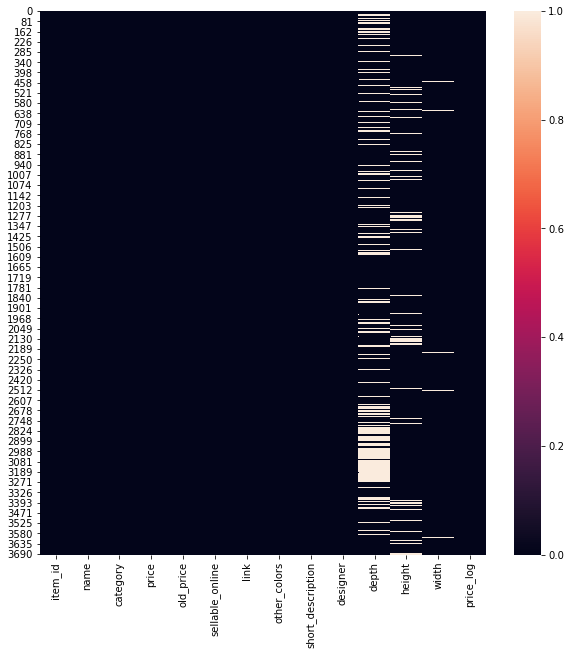

In [214]:
# visual represenation of the NAs in the dataset
plt.figure(figsize=(10, 10))
sns.heatmap(ikea.isna());

In [143]:
# quickly check how many items we may be able to preseve if we attempt to impute a single missing dimension and drop those with more than two missing.
drop_index = ikea.isna().sum(axis=1) > 1
ikea.drop(ikea[drop_index].index).isna().sum()

item_id                0
name                   0
category               0
price                  0
old_price              0
sellable_online        0
link                   0
other_colors           0
short_description      0
designer               0
depth                692
height               251
width                 24
dtype: int64

In [144]:
# drop rows with 2 or more missing values
ikea.drop(ikea[drop_index].index, inplace=True)

## Data Visualizations

Next, we will quickly tale a look at our features as compared to our target variable.  When we look at the `price` variable, we see that it ranges from a minimum of 5 to a maximum of 9585.  To contend with this large range, we will do a log-transformation on the `price`.  We will quickly chart the target vs each or the dimensions and against the various categories.

For the `categpry` feature, we see that we have 17 different categories, likely too many for our model given the small number of observations, we will take the 11 largest categories and combine the remaining categories into one called `other`.  

From all these visuals, there does not appear to be great predictive value in any one feature, so we must temper our expectations of our model predictions.

In [218]:
# quick summary statistics of our target variable
ikea['price'].describe()

count    2866.000000
mean     1113.905652
std      1401.535864
min         5.000000
25%       220.000000
50%       585.000000
75%      1468.000000
max      9585.000000
Name: price, dtype: float64

In [145]:
# log-transformation of our target variable
ikea["price_log"] = np.log(ikea["price"])

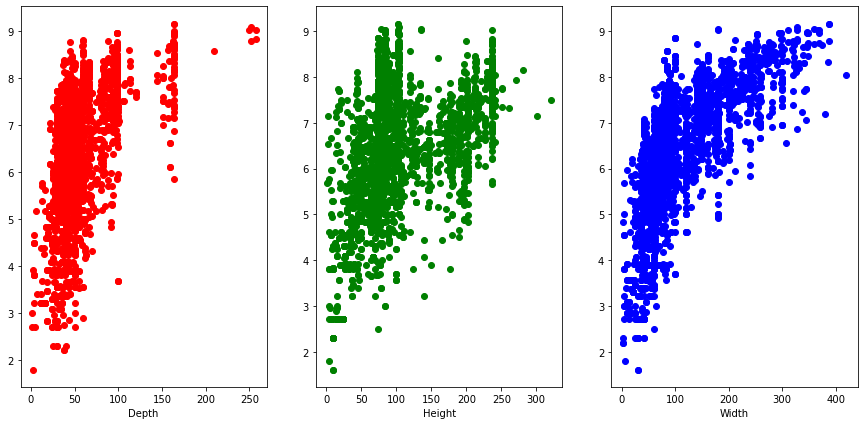

In [146]:
# visual the relationship between our numeric predictors vs our target
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (15, 7))
ax1.scatter("depth", "price_log", data=ikea, color = "red")
ax1.set_xlabel("Depth")

ax2.scatter("height", "price_log", data=ikea, color = "green")
ax2.set_xlabel("Height")

ax3.scatter("width", "price_log", data=ikea, color = "blue")
ax3.set_xlabel("Width");

In [147]:
# observations in each of our categorical variable
ikea["category"].value_counts()

Bookcases & shelving units              493
Tables & desks                          390
Chairs                                  334
Sofas & armchairs                       271
Cabinets & cupboards                    254
Wardrobes                               233
TV & media furniture                    152
Beds                                    150
Outdoor furniture                       148
Chests of drawers & drawer units        123
Children's furniture                    111
Nursery furniture                        87
Bar furniture                            37
Trolleys                                 27
Sideboards, buffets & console tables     23
Café furniture                           21
Room dividers                            12
Name: category, dtype: int64

In [148]:
# reduce the categories to only 10, with at least 111 items in each category
top_11_cats = ikea["category"].value_counts().head(11).index
ikea["category"] = ikea["category"].apply(lambda cat: "Other" if cat not in top_11_cats else cat)
ikea["category"].value_counts()

Bookcases & shelving units          493
Tables & desks                      390
Chairs                              334
Sofas & armchairs                   271
Cabinets & cupboards                254
Wardrobes                           233
Other                               207
TV & media furniture                152
Beds                                150
Outdoor furniture                   148
Chests of drawers & drawer units    123
Children's furniture                111
Name: category, dtype: int64

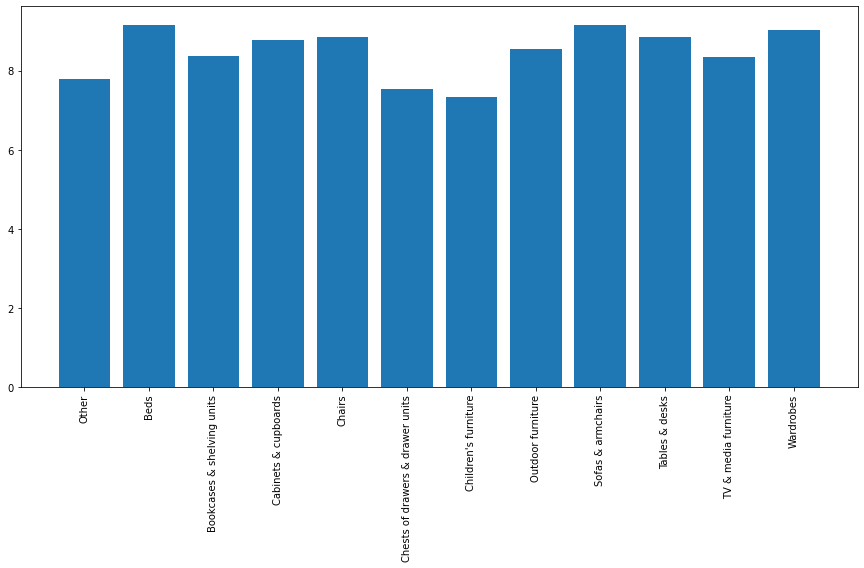

In [149]:
# visualize how our target variable varies among the categories
plt.figure(figsize=(15, 7))
plt.xticks(rotation=90)
plt.bar("category", "price_log", data=ikea);

## Data Preparation

We have done some feature engineering above.  But we will need to category to ensure that our data is prepared to be entered into a model.  

First, we will subset our dataset into the X (predictors or features) and y (target).  We will then create a training set, in which we will use to fit the model, and a test set, over which we will evaluate the model.

**Numerical variables**  
For the numerical variables, we still need to replace our missing values.  As mentioned we will use the KNN model to impute the missing values from the known dimensions.  In the KNN algorithm, we will use 3 nearest neighbors, meaning that we will find the 3 closest obeservations to determine the missing value.  The closest observations will be found by calculating the eclidian distance between each observation and then simply using the 3 closest to imput the missing value.
*Note: When performing the transformation, we fit and transform the training set, but then simply use that fit to only transform the test set.*

**Categorical variables**
For the categorical variables, we will use One-Hot Encoding to convert the categories into numeric values.  In One-Hot Encoding, we simply create a dummy feature for each category with a value of 1 or 0 for each variable depending if the category pertains to that observation or not.  

Lastly, we concatenate the numeric and categorical feature back into a single DataFrame ready for modeling.

In [153]:
# create our X and Y variables
X = ikea[['category', 'depth', 'height', 'width']]
y = ikea['price_log']

X.shape, y.shape

((2866, 4), (2866,))

In [155]:
# create our train and set datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2149, 4), (717, 4), (2149,), (717,))

In [219]:
# subset our numeric features for both test and train
num_cats = ['depth', 'height', 'width']
X_train_num = X_train[num_cats]
X_test_num = X_test[num_cats]

# perform the imputation using KNN, with 3 neighbors (copy=False allows for in-place transformations)
imputer = KNNImputer(n_neighbors=3, copy=False)
imputer.fit_transform(X_train_num)
imputer.transform(X_test_num)               

X_train_num.shape, X_test_num.shape

((2149, 3), (717, 3))

In [169]:
# confirm the NAs have been replaced
X_train_num.isnull().sum(), X_test_num.isnull().sum()

(depth     0
 height    0
 width     0
 dtype: int64,
 depth     0
 height    0
 width     0
 dtype: int64)

In [176]:
# perform the One-Hot encoding for the categorical feature
One_Hot = OneHotEncoder(handle_unknown='ignore', sparse=False)

X_train_cat = X_train[['category']]
X_test_cat = X_test[['category']]

X_train_cat = pd.DataFrame(One_Hot.fit_transform(X_train_cat))
X_test_cat = pd.DataFrame(One_Hot.transform(X_test_cat))

# One-Hot Encoding drops the index, so we need to replace it
X_train_cat.index = X_train.index
X_test_cat.index = X_test.index

X_train_cat.shape, X_test_cat.shape

((2149, 12), (717, 12))

In [181]:
# recombine the transformed datasets for modeling
X_train_trans = pd.concat([X_train_num, X_train_cat], axis=1)
X_test_trans = pd.concat([X_test_num, X_test_cat], axis=1)

X_train_trans.shape, X_test_trans.shape

((2149, 15), (717, 15))

## Train the Model

Now, that our data has been transformed for modeling, we can run our initial base model.  Here we will use n_estimators of 200 (we will discuss this in the tuning section).  We will then use that fitted model to make predictions on our test data.  Those predictions will allow us to evaluate our model.  We will use a simple Mean Absolute Error for evaluation.  We must remember to transform our predictions back so that the MAE makes more intuitive sense.

We didn't have high expectations for the model, and a MAE of 396 or 35% isn't very impressive.  Next, we will see if we tuning the model improves our predictive capacity.

In [188]:
# Instatiate the model, fit the model to the training data, predict on the test, and evaluate the results
rf_model = RandomForestRegressor(n_estimators=200, random_state=42)

rf_model.fit(X_train_trans, y_train)
preds = rf_model.predict(X_test_trans)

mean_absolute_error(y_test, preds)

0.4496975465145763

In [196]:
# Remember to transform the target back for easier understanding
mean_absolute_error(np.exp(y_test), np.exp(preds)), ikea['price'].mean()

(396.9394406603129, 1113.90565247732)

## Tune the Model

Here we will look to tune the model's hyperparamters.  The Random Forest model has a variety of tuning parameters, we will focus on 4 here.

* n_estimators: the number of trees that will be constructed  
* max_depth: maximum number of levels of each tree  
* min_samples_split: minimum number of items requires to split at a node
* min_samples_leaf: minimum number of items at each leaf node

Other parameters that can be tuned:  
* max_features: which is the number of features to be considered at each split
* bootstrap: whether to use bootstrapping to selct the samples.

When tuning you provide a range of inputs that you want the model to calculate over, based on what is chosen below this would leave $6*10*3*3$ or 540 iterations of the model.  Rather than doing each iteration which would be done using `GridSearchCV`, we will utilize `RandomizedSearchCV` which will perform a choose random searches up to the defined number of iterations, we will run 50. 

In addition, in order to find the best parameters, we will utilize cross-validation with 5 folds.  This will divide our training set into 5 groups, in the first run, it will train on groups (1,2,3,4) and evaluate on 5, in the 2nd run, it will train on groups (1,2,3,5) and test on 4...etc.  We will perform this cross-validation on each of the 50 randomly choosen parameter sets and the model will output the best set of parameters for us to use.

In [203]:
# define the parameters and ranges to tune over)
n_estimators = [int(x) for x in np.linspace(start=200,stop=1200, num=6)]
max_depth = [int(x) for x in np.linspace(10, 50, 10)]
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]

random_grid = {'n_estimators': n_estimators,
              'max_depth': max_depth,
              'min_samples_split': min_samples_split,
              'min_samples_leaf': min_samples_leaf
              }
random_grid, (6*10*3*3)

({'n_estimators': [200, 400, 600, 800, 1000, 1200],
  'max_depth': [10, 14, 18, 23, 27, 32, 36, 41, 45, 50],
  'min_samples_split': [2, 5, 10],
  'min_samples_leaf': [1, 2, 4]},
 540)

In [231]:
# tune and fit the model to the training data
rf = RandomForestRegressor(verbose=0)
rf_random = RandomizedSearchCV(estimator=rf,
                              param_distributions=random_grid,
                              n_iter=50,
                              cv=5,
                              verbose=0,
                              random_state=42)

rf_random.fit(X_train_trans, y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_iter=50,
                   param_distributions={'max_depth': [10, 14, 18, 23, 27, 32,
                                                      36, 41, 45, 50],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200]},
                   random_state=42)

In [240]:
rf_model.estimators_

[DecisionTreeRegressor(max_features='auto', random_state=1608637542),
 DecisionTreeRegressor(max_features='auto', random_state=1273642419),
 DecisionTreeRegressor(max_features='auto', random_state=1935803228),
 DecisionTreeRegressor(max_features='auto', random_state=787846414),
 DecisionTreeRegressor(max_features='auto', random_state=996406378),
 DecisionTreeRegressor(max_features='auto', random_state=1201263687),
 DecisionTreeRegressor(max_features='auto', random_state=423734972),
 DecisionTreeRegressor(max_features='auto', random_state=415968276),
 DecisionTreeRegressor(max_features='auto', random_state=670094950),
 DecisionTreeRegressor(max_features='auto', random_state=1914837113),
 DecisionTreeRegressor(max_features='auto', random_state=669991378),
 DecisionTreeRegressor(max_features='auto', random_state=429389014),
 DecisionTreeRegressor(max_features='auto', random_state=249467210),
 DecisionTreeRegressor(max_features='auto', random_state=1972458954),
 DecisionTreeRegressor(max_f

In [232]:
# retrieve the best parameters
rf_random.best_params_

{'n_estimators': 1200,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_depth': 23}

In [233]:
# predict on the test set and evaluate the best model parameters
rf_best= rf_random.best_estimator_

preds = rf_best.predict(X_test_trans)

mean_absolute_error(np.exp(y_test), np.exp(preds))

397.27203830019045

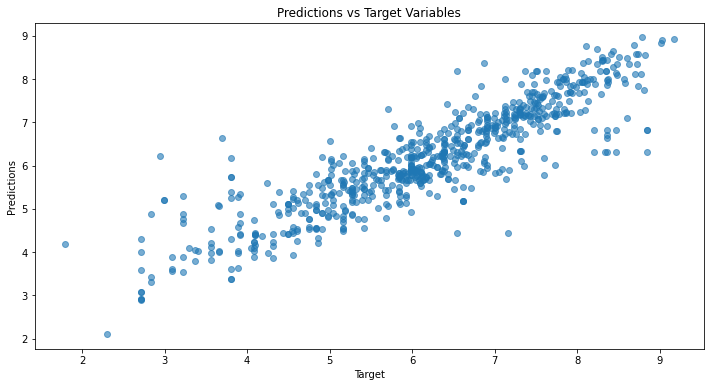

In [234]:
plt.figure(figsize=(12, 6))
plt.scatter(y_test, preds, alpha=0.6)
plt.title("Predictions vs Target Variables")
plt.xlabel("Target")
plt.ylabel("Predictions");

## Conclusion:

Visually, our model seems to have done a reasonable just at estimating price, even if our MAE is still near 400.  And unfortunately, tuning the model did not improve the predictions on our test data.  This isn't entirely suprising given the preliminary analysis we did in the beginning.  However, we were able to work through some feature engineering and do some model tuning along the way.

References:

*Tune random forests for #TidyTuesday IKEA prices*:   https://juliasilge.com/blog/ikea-prices/  

*Hyperparameter Tuning the Random Forest in Python*: https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74